# **Article count prediction**

---


Using the hourly user traffic data provided,  you need to forecast the traffic for next 2 weeks. 


---

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daily-traffic-count/train.csv
/kaggle/input/daily-traffic-count/test.csv
/kaggle/input/daily-traffic-count/sample_submission.csv


In [2]:
import pandas as pd
import os
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import datetime

from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from statistics import mean 

%matplotlib inline             
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace import sarimax
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

import warnings
warnings.filterwarnings("ignore")

### importing data:

In [3]:
df = pd.read_csv('../input/daily-traffic-count/train.csv')
test = pd.read_csv('../input/daily-traffic-count/test.csv')
submit = pd.read_csv('../input/daily-traffic-count/sample_submission.csv')

In [4]:
df.columns = ['id','datetime','read_count']

### changing date column to datetime format

In [5]:
df['datetime'] = pd.to_datetime(df['datetime'],infer_datetime_format=True)

df.timestamp = pd.to_datetime(df['datetime'],infer_datetime_format=True) #format='%Y-%m-%d')
df.index = df.timestamp

df['datetime'] = pd.to_datetime(df['datetime'],infer_datetime_format=True) 
df.dtypes

id                     int64
datetime      datetime64[ns]
read_count             int64
dtype: object

In [6]:
df.head()

,id,datetime,read_count
datetime,,,
2019-07-01 00:00:00,1,2019-07-01 00:00:00,1421
2019-07-01 01:00:00,2,2019-07-01 01:00:00,1116
2019-07-01 02:00:00,3,2019-07-01 02:00:00,921
2019-07-01 03:00:00,4,2019-07-01 03:00:00,824
2019-07-01 04:00:00,5,2019-07-01 04:00:00,737


In [7]:
train = df[0:3648]
val = df[3648:]

In [8]:
train.shape, val.shape

((3648, 3), (912, 3))

## Brief Analysis

In [8]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3648.0,1824.500000,1053.231219,1.0,912.75,1824.5,2736.25,3648.0
read_count,3648.0,2329.609375,925.738756,572.0,1573.00,2208.0,3080.25,6074.0


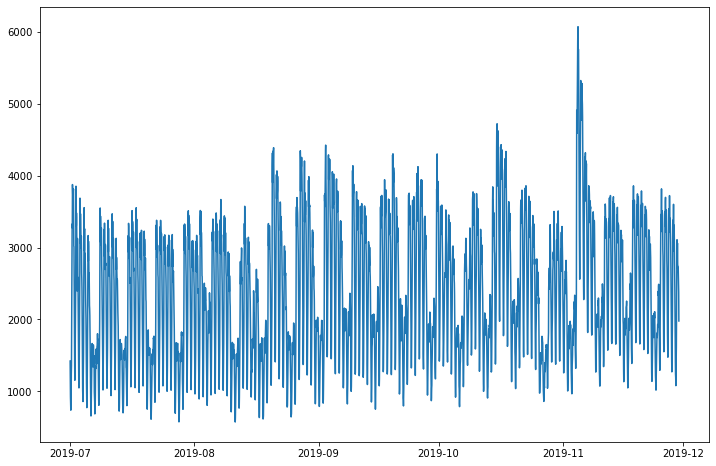

In [9]:
## plot graph

plt.figure(figsize=(12,8))

plt.plot(train.index, train['read_count'])

In [10]:
train[(train.read_count) >5000]

,id,datetime,read_count
datetime,,,
2019-11-04 15:00:00,3040,2019-11-04 15:00:00,5387
2019-11-04 16:00:00,3041,2019-11-04 16:00:00,5491
2019-11-04 17:00:00,3042,2019-11-04 17:00:00,5878
2019-11-04 18:00:00,3043,2019-11-04 18:00:00,6061
2019-11-04 19:00:00,3044,2019-11-04 19:00:00,6074
2019-11-04 20:00:00,3045,2019-11-04 20:00:00,5760
2019-11-04 21:00:00,3046,2019-11-04 21:00:00,5760
2019-11-04 22:00:00,3047,2019-11-04 22:00:00,5756
2019-11-04 23:00:00,3048,2019-11-04 23:00:00,5173


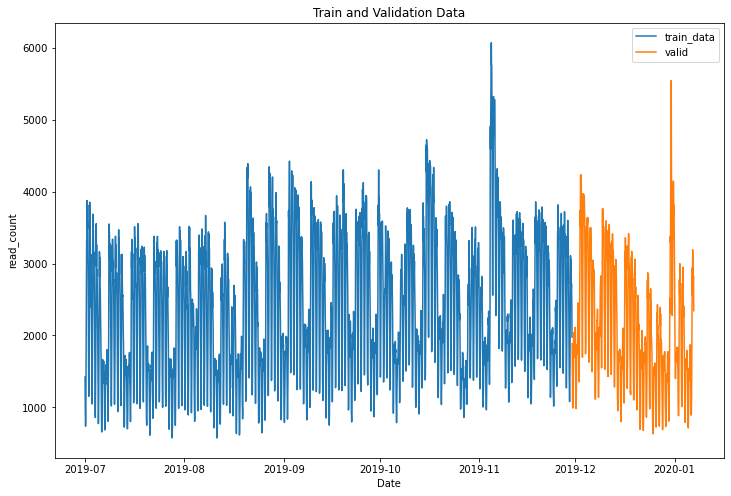

In [11]:
## plot graph

plt.figure(figsize=(12,8))

plt.plot(train.index, train['read_count'], label='train_data')
plt.plot(val.index,val['read_count'], label='valid')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('read_count')
plt.title("Train and Validation Data")
plt.show()

## Stationary tests:
    a. adf test
    b. kpss test

In [12]:
# dickey fuller, KPSS

def adf_test(timeseries):
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [13]:
adf_test(train['read_count'])

Results of Dickey-Fuller Test:
Test Statistic                -7.988959e+00
p-value                        2.504394e-12
#Lags Used                     2.900000e+01
Number of Observations Used    3.618000e+03
Critical Value (1%)           -3.432159e+00
Critical Value (5%)           -2.862339e+00
Critical Value (10%)          -2.567195e+00
dtype: float64


In [14]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [15]:
kpss_test(train['read_count'])

Results of KPSS Test:
Test Statistic            1.26053
p-value                   0.01000
Lags Used                30.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


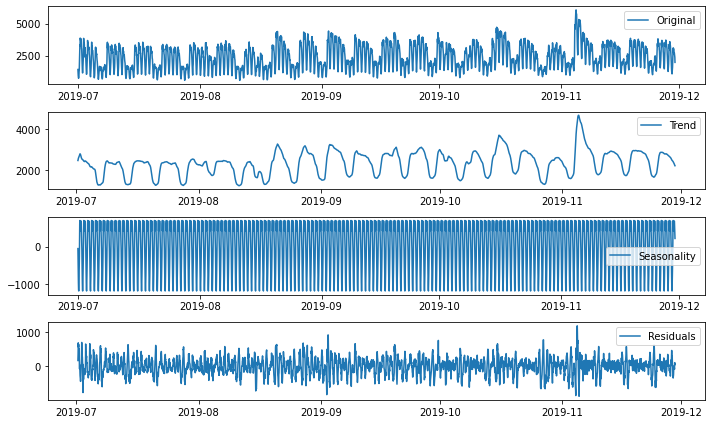

In [16]:
decomposition = seasonal_decompose(train[['read_count']]) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(train['read_count'], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
# test_stationarity(decomposedLogData)

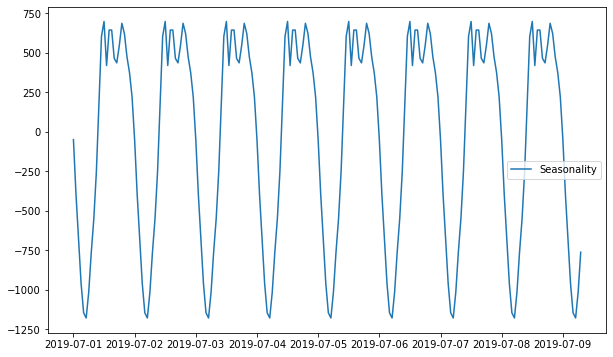

In [17]:
plt.plot(seasonal[0:200], label='Seasonality')
plt.legend(loc='best')

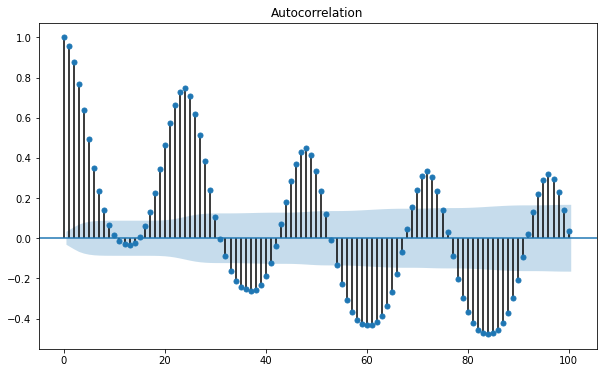

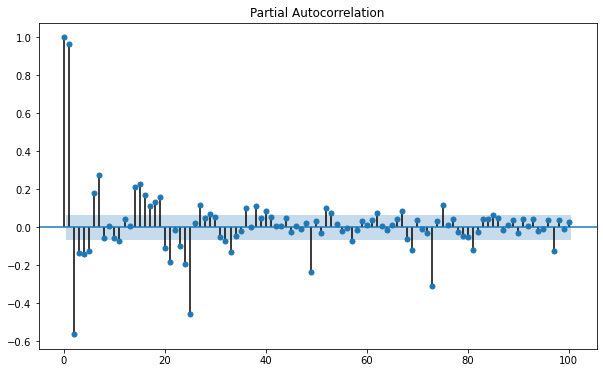

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train['read_count'].dropna(), lags=100)
plot_pacf(val['read_count'].dropna(), lags=100)
plt.show()

## AR model 

In [19]:
# fit model
model = ARIMA(train['read_count'], order=(7,0,0))
model_fit = model.fit()

In [20]:
# gernerate forecasts
output = model_fit.forecast(912) 

val['Ar'] = (pd.DataFrame(output)).values

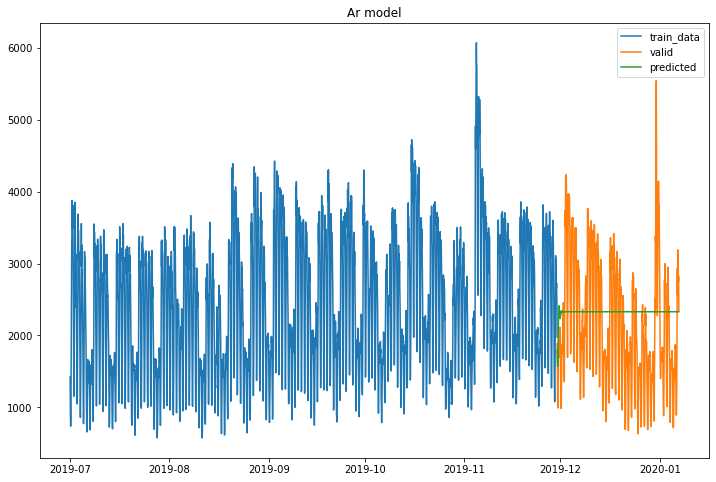

In [21]:

plt.figure(figsize=(12,8))

plt.plot(train.index, train['read_count'], label='train_data')
plt.plot(val.index, val['read_count'], label='valid')
plt.plot(val.index, val['Ar'], label='predicted')

plt.legend(loc='best')
plt.title("Ar model")
plt.show()

In [22]:
np.sqrt(mse(val['read_count'],val['Ar']))

878.0958275545514

## MA model

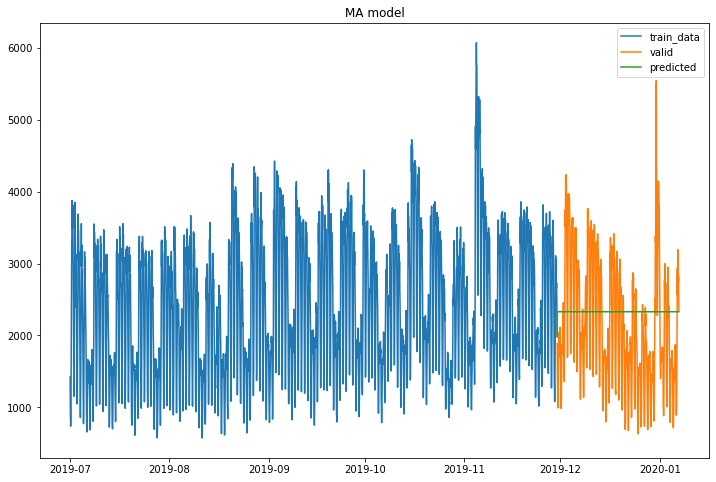

In [23]:
# fit model
model = ARIMA(train['read_count'].dropna(), order=(0,0,1))
model_fit = model.fit()

# gernerate forecasts
output = model_fit.forecast(912) 

val['MA'] = (pd.DataFrame(output)).values


plt.figure(figsize=(12,8))

plt.plot(train.index, train['read_count'], label='train_data')
plt.plot(val.index, val['read_count'], label='valid')
plt.plot(val.index, val['MA'], label='predicted')

plt.legend(loc='best')
plt.title("MA model")
plt.show()

In [24]:
np.sqrt(mse(val['read_count'],val['MA']))

882.9415492853182

## ARIMA model

Applying differencing of 1
d- 1


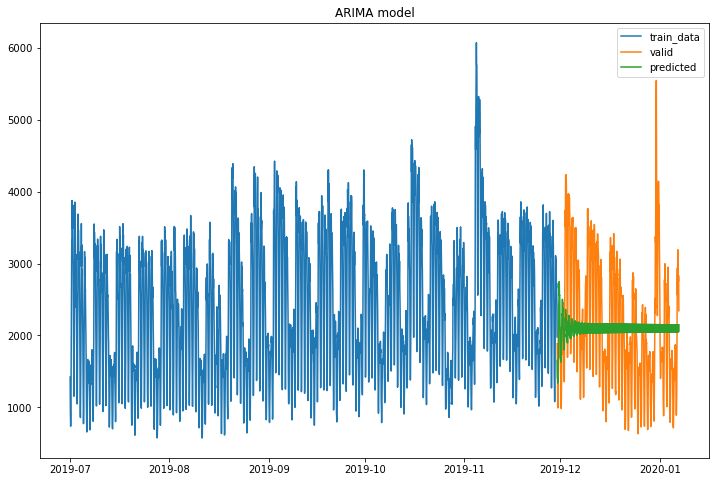

In [25]:
# fit model
model = ARIMA(train['read_count'].dropna(), order=(7,1,7))
model_fit = model.fit()

# gernerate forecasts
output = model_fit.forecast(912) 

val['ARIMA'] = (pd.DataFrame(output)).values


# plot the graph
plt.figure(figsize=(12,8))

plt.plot(train.index, train['read_count'], label='train_data')
plt.plot(val.index, val['read_count'], label='valid')
plt.plot(val.index, val['ARIMA'], label='predicted')

plt.legend(loc='best')
plt.title("ARIMA model")
plt.show()

In [26]:
np.sqrt(mse(val['read_count'],val['ARIMA']))

839.8141670765244

## SARIMA model

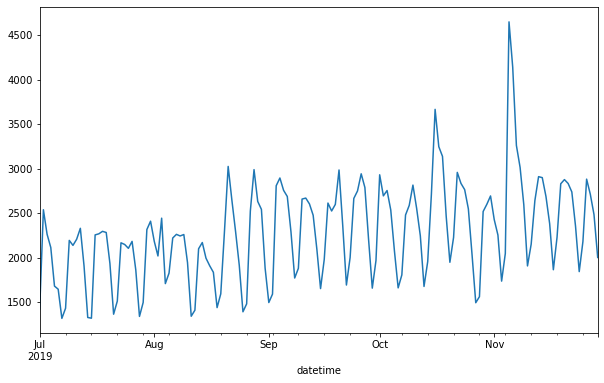

In [27]:
train['read_count'].asfreq('D').plot()

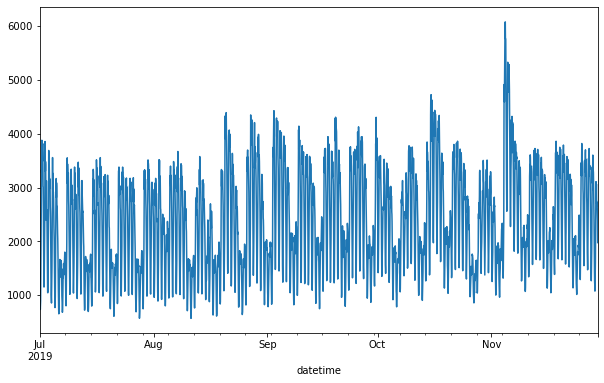

In [28]:
train['read_count'].asfreq('h').plot()

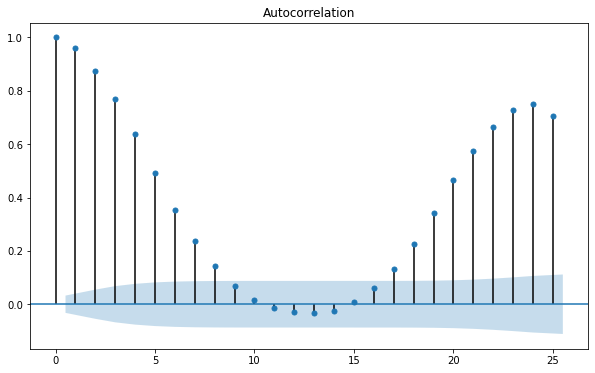

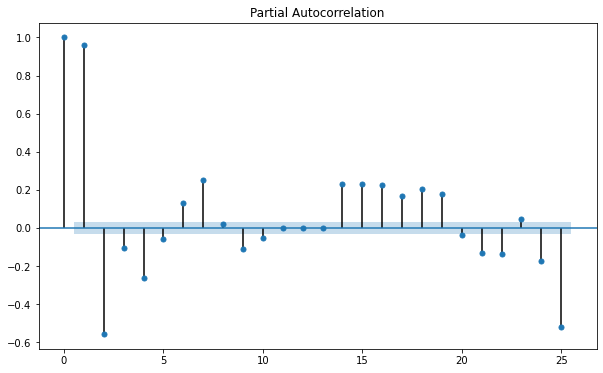

In [29]:
plot_acf(train['read_count'].dropna(), lags=25)
plot_pacf(train['read_count'].dropna(), lags=25)
plt.show()

In [30]:
#seasonal differencing

train['read_count_day']= train['read_count'] -train['read_count'].shift(1)
train['read_count_h']= train['read_count'] -train['read_count'].shift(24)

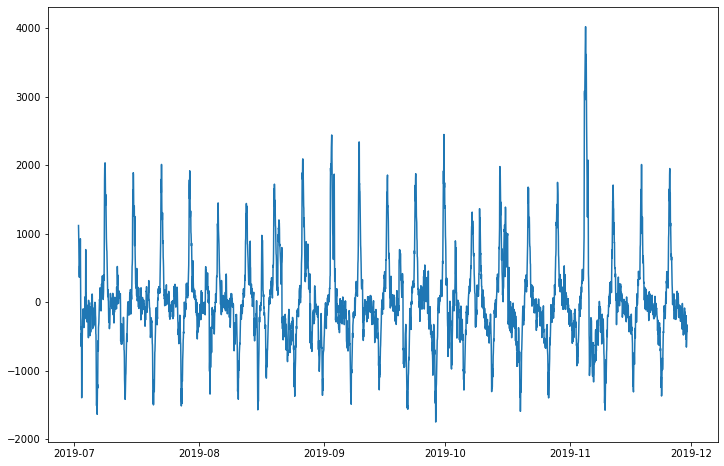

In [31]:
# plot the graph
plt.figure(figsize=(12,8))

plt.plot(train.index, train['read_count_h'], label='train_data')

In [32]:
adf_test(train['read_count_h'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -9.502591e+00
p-value                        3.413517e-16
#Lags Used                     2.900000e+01
Number of Observations Used    3.594000e+03
Critical Value (1%)           -3.432171e+00
Critical Value (5%)           -2.862345e+00
Critical Value (10%)          -2.567198e+00
dtype: float64


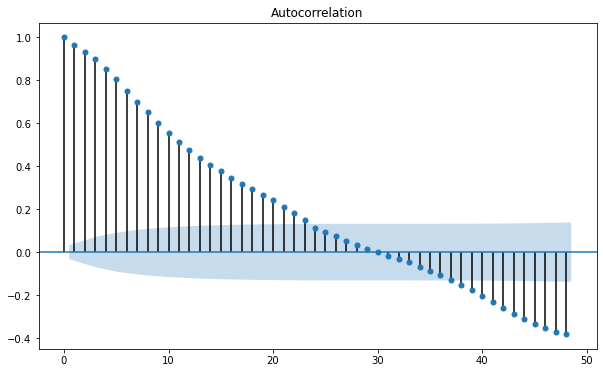

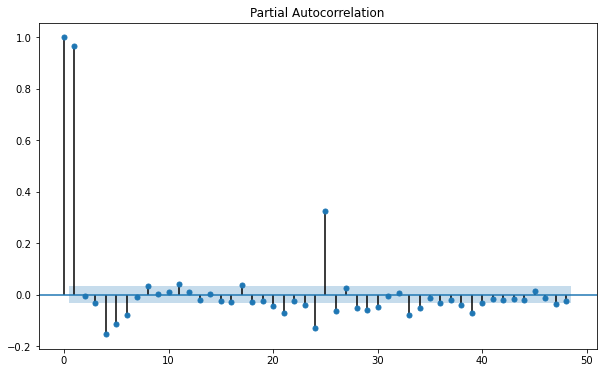

In [33]:
plot_acf(train['read_count_h'].dropna(), lags=48)
plot_pacf(train['read_count_h'].dropna(), lags=48)
plt.show()

**SARIMA**

In [34]:
model =  sarimax.SARIMAX(train['read_count'],order = (1,0,0),seasonal_order = (6,1,1,24))
results = model.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           read_count   No. Observations:                 3648
Model:             SARIMAX(1, 0, 0)x(6, 1, [1], 24)   Log Likelihood              -22611.520
Date:                              Tue, 27 Oct 2020   AIC                          45241.039
Time:                                      05:18:19   BIC                          45296.797
Sample:                                  07-01-2019   HQIC                         45260.903
                                       - 11-29-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9589      0.003    308.258      0.000       0.953       0.965
ar.S.L24      -0.63

In [35]:
# gernerate forecasts
output = results.forecast(912) 

val['Sarima'] = pd.DataFrame(output).values

In [36]:
test.max(),test.min()

(id                         4896
 datetime    2020-01-20 23:00:00
 dtype: object,
 id                         4561
 datetime    2020-01-07 00:00:00
 dtype: object)

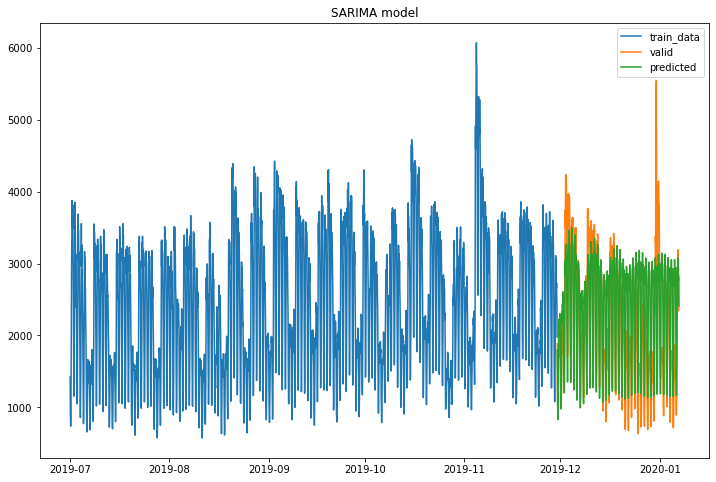

In [37]:
plt.figure(figsize=(12,8))

plt.plot(train.index, train['read_count'], label='train_data')
plt.plot(val.index, val['read_count'], label='valid')
plt.plot(val.index, val['Sarima'], label='predicted')

plt.legend(loc='best')
plt.title("SARIMA model")
plt.show()

In [38]:
np.sqrt(mse(val['read_count'],val['Sarima']))

637.2517572166201

In [ ]:
# gernerate forecasts
output12a = results.predict(start='2020-01-07 00:00:00',end='2020-01-20 23:00:00') 

submit['total_articles_read'] = pd.DataFrame(output12a).values

submit.to_csv('sub1234.csv',index=False)

## Removing outliers

In [9]:
train1 = train.copy()
val1 = val.copy()

In [10]:
train1.head()

,id,datetime,read_count
datetime,,,
2019-07-01 00:00:00,1,2019-07-01 00:00:00,1421
2019-07-01 01:00:00,2,2019-07-01 01:00:00,1116
2019-07-01 02:00:00,3,2019-07-01 02:00:00,921
2019-07-01 03:00:00,4,2019-07-01 03:00:00,824
2019-07-01 04:00:00,5,2019-07-01 04:00:00,737


In [11]:
train1.loc[train1['read_count']>train1['read_count'].quantile(0.99),'read_count']=train1['read_count'].quantile(0.99)
train1.loc[train1['read_count']<train1['read_count'].quantile(0.01),'read_count']=train1['read_count'].quantile(0.01)
train1.describe(percentiles=[0.01,0.05,0.95,0.99]).T

,count,mean,std,min,1%,5%,50%,95%,99%,max
id,3648.0,1824.500000,1053.231219,1.00,37.4700,183.35,1824.5,3465.65,3611.5300,3648.00
read_count,3648.0,2324.186519,906.969976,758.94,759.4382,997.05,2208.0,3787.30,4408.7416,4414.72


In [12]:
val2 = val1.copy()
val2.loc[val2['read_count']>val2['read_count'].quantile(0.99),'read_count']=val2['read_count'].quantile(0.99)
val2.loc[val2['read_count']<val2['read_count'].quantile(0.01),'read_count']=val2['read_count'].quantile(0.01)
val2.describe(percentiles=[0.01,0.05,0.95,0.99]).T

,count,mean,std,min,1%,5%,50%,95%,99%,max
id,912.0,4104.500000,263.416021,3649.00,3658.1100,3694.55,4104.5,4514.45,4550.8900,4560.00
read_count,912.0,2087.264035,831.740517,725.77,726.4553,901.85,1902.5,3608.15,4156.1289,4157.01


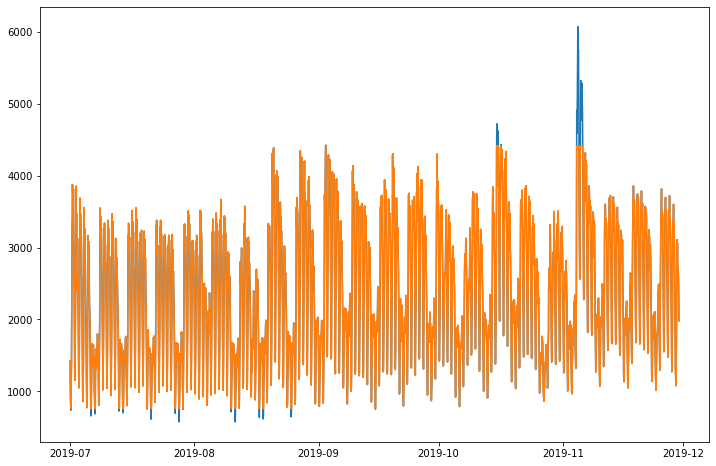

In [13]:
plt.figure(figsize=(12,8))

plt.plot(train.index, train['read_count'], label='train_data')
plt.plot(train1.index, train1['read_count'], label='train_data1')

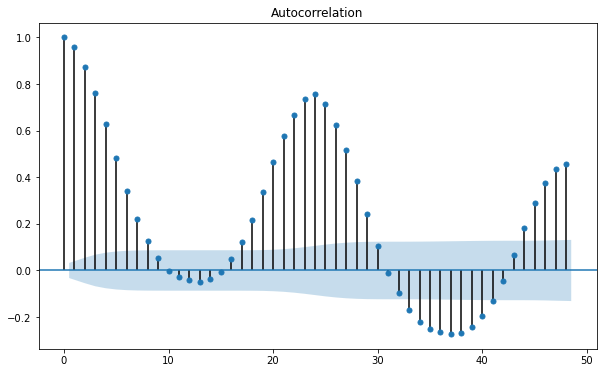

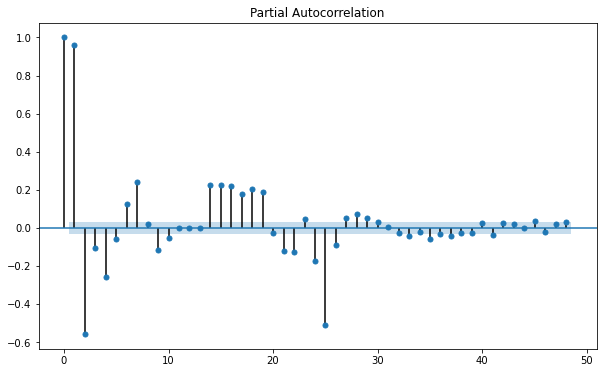

In [14]:
plot_acf(train1['read_count'].dropna(), lags=48)
plot_pacf(train1['read_count'].dropna(), lags=48)
plt.show()

In [15]:
#seasonal differencing

train1['read_count_day']= train1['read_count'] -train1['read_count'].shift(1)
train1['read_count_h']= train1['read_count'] -train1['read_count'].shift(24)

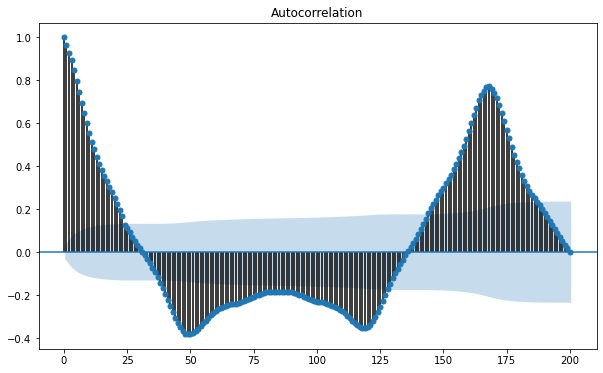

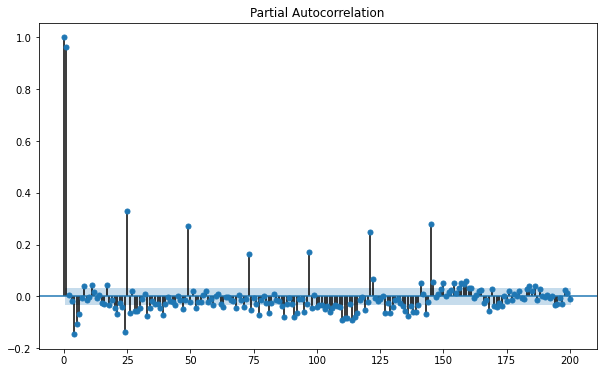

In [16]:

plot_acf(train1['read_count_h'].dropna(), lags=200)
plot_pacf(train1['read_count_h'].dropna(), lags=200)
plt.show()

In [ ]:

# gc.collect()

## SARIMA model - after removing outliers

In [ ]:
#again running sarima model:

model =  sarimax.SARIMAX(train1['read_count'],order = ((1,1,0,1,1,1,1),0,6),seasonal_order = (6,1,7,24))

# SARIMAX(train, order=(1,1,2), seasonal_order(1,1,2,7)).fit(max_iter = 50,method = 'powell')
results = model.fit()
print(results.summary())

In [ ]:
# gernerate forecasts
output = results.forecast(912) 

val['Sarima'] = pd.DataFrame(output).values

In [ ]:
test.max(),test.min()

In [ ]:
plt.figure(figsize=(12,8))

plt.plot(train1.index, train1['read_count'], label='train_data')
plt.plot(val.index, val['read_count'], label='valid')
plt.plot(val.index, val['Sarima'], label='predicted')

plt.legend(loc='best')
plt.title("SARIMA model")
plt.show()

In [30]:
# gernerate forecasts
output12g = results.predict(start='2020-01-07 00:00:00',end='2020-01-20 23:00:00') 

submit['total_articles_read'] = pd.DataFrame(output12g).values

#save to a file
submit.to_csv('sub12g.csv',index=False)

In [38]:
np.sqrt(mse(val['read_count'],val['Sarima']))

726.566039776574

In [31]:
df.shape

(4560, 3)

## Running model on section of train dataset:

In [10]:
data1 = df[3120:]


In [11]:
data1.loc[data1['read_count']>data1['read_count'].quantile(0.99),'read_count']=data1['read_count'].quantile(0.99)
data1.loc[data1['read_count']<data1['read_count'].quantile(0.01),'read_count']=data1['read_count'].quantile(0.01)
data1.describe(percentiles=[0.01,0.05,0.95,0.99]).T

,count,mean,std,min,1%,5%,50%,95%,99%,max
id,1440.0,3840.500000,415.836506,3121.00,3135.3900,3192.95,3840.5,4488.05,4545.6100,4560.00
read_count,1440.0,2232.389688,826.639242,758.19,763.1859,989.65,2064.0,3603.10,4043.7442,4044.22


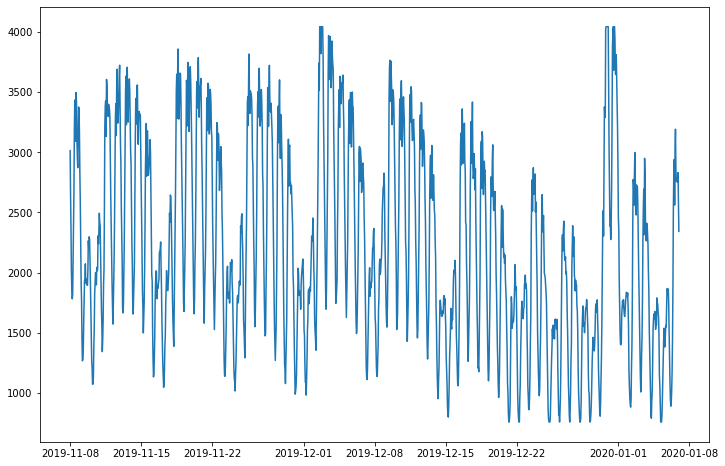

In [12]:
plt.figure(figsize=(12,8))

plt.plot(data1.index, data1['read_count'], label='train_data')

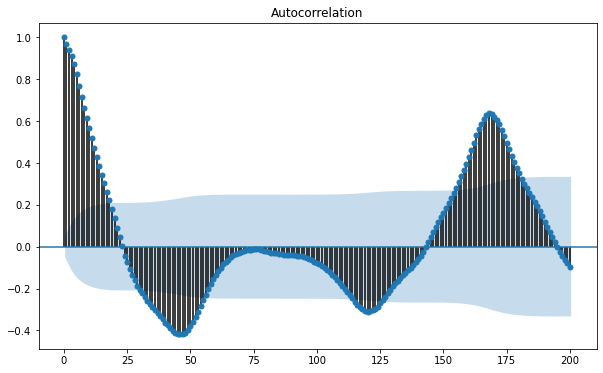

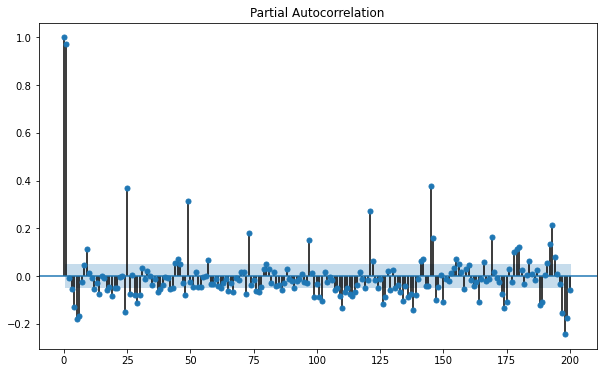

In [13]:
#seasonal differencing

data1['read_count_day']= data1['read_count'] -data1['read_count'].shift(1)
data1['read_count_h']= data1['read_count'] -data1['read_count'].shift(24)

plot_acf(data1['read_count_h'].dropna(), lags=200)
plot_pacf(data1['read_count_h'].dropna(), lags=200)
plt.show()

In [36]:
#again running sarima model:

model =  sarimax.SARIMAX(data1['read_count'],order = ((1,1,0,1,1,1,1),0,6),seasonal_order = (5,1,7,24))

results = model.fit()
print(results.summary())

                                                        SARIMAX Results                                                        
Dep. Variable:                                                              read_count   No. Observations:                 1440
Model:             SARIMAX([1, 2, 4, 5, 6, 7], 0, 6)x(5, 1, [1, 2, 3, 4, 5, 6, 7], 24)   Log Likelihood               -8729.012
Date:                                                                 Mon, 26 Oct 2020   AIC                          17508.024
Time:                                                                         16:11:41   BIC                          17639.414
Sample:                                                                     11-08-2019   HQIC                         17557.113
                                                                          - 01-06-2020                                         
Covariance Type:                                                                   opg                  

In [37]:
# gernerate forecasts
output12k = results.predict(start='2020-01-07 00:00:00',end='2020-01-20 23:00:00') 

submit['total_articles_read'] = pd.DataFrame(output12k).values

#save to a file
submit.to_csv('sub12k.csv',index=False)

GARCH model

In [16]:
!pip install arch

     |████████████████████████████████| 790 kB 401 kB/s eta 0:00:01


In [17]:
from random import gauss
from random import seed
from matplotlib import pyplot
from arch import arch_model
# seed pseudorandom number generator
seed(1)
# create dataset
data = data1
# split into train/test
# n_test = 10
# train, test = data[:-n_test], data[-n_test:]
# define model
model = arch_model(data1['read_count'], mean='Zero', vol='GARCH', p=6, q=8)
# fit model
model_fit = model.fit()


Iteration:      1,   Func. Count:     17,   Neg. LLF: 13180.281008513748
Iteration:      2,   Func. Count:     34,   Neg. LLF: 13065.278249035433
Iteration:      3,   Func. Count:     52,   Neg. LLF: 13060.839853139973
Iteration:      4,   Func. Count:     69,   Neg. LLF: 13060.290219038576
Iteration:      5,   Func. Count:     86,   Neg. LLF: 13060.237885018967
Iteration:      6,   Func. Count:    103,   Neg. LLF: 13060.237493961338
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 13060.237492721288
            Iterations: 6
            Function evaluations: 103
            Gradient evaluations: 6


In [ ]:
# forecast the test set
yhat = model_fit.forecast(horizon=n_test)
# plot the actual variance
var = [i*0.01 for i in range(0,100)]
pyplot.plot(var[-n_test:])
# plot forecast variance
pyplot.plot(yhat.variance.values[-1, :])
pyplot.show()

In [19]:
test.shape

(336, 2)

In [21]:
# # gernerate forecasts
# output12k = model_fit.forecast(336) 

# submit['total_articles_read'] = pd.DataFrame(output12k).values

# #save to a file
# submit.to_csv('sub12k.csv',index=False)